In [2]:
import numpy as np
import pandas as pd
import os
from scipy.signal import find_peaks, welch
from scipy.integrate import simpson
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.combine import SMOTETomek

In [3]:
# Extract files that contain PPG signals
with_ppg = []
for dirname, _, filenames in os.walk('/Users/sarahalabdulrazzak/Desktop/Capstone/myenv/Data/Challenge2015_csv/'):
    for filename in filenames:
        if filename != "ALARMS":
            if "PLETH" in pd.read_csv(dirname + filename).columns:
                with_ppg.append(filename[0:-4])

# Read alarm labels
df = pd.read_csv("/Users/sarahalabdulrazzak/Desktop/Capstone/myenv/Data/Challenge2015_csv/ALARMS",
                 names=["Sample", "Label", "TrueAlarm"])

# Exclude Asystole cases
df_relevant = df[df["Label"] != "Asystole"].copy()

# Keep only data that has PPG available
df_filtered = df_relevant[df_relevant["Sample"].isin(with_ppg)].copy()
df_filtered["Path"] = ["/Users/sarahalabdulrazzak/Desktop/Capstone/myenv/Data/Challenge2015_csv/" + x + ".csv"
                       for x in df_filtered["Sample"]]

# Extract AFib and Healthy Data
afib_paths = []
healthy_paths = []
afib_samples = []
healthy_samples = []

for dirname, _, filenames in os.walk('/Users/sarahalabdulrazzak/Desktop/Capstone/myenv/Data/mimic_perform_af_csv'):
    for filename in filenames:
        if "csv" in filename:
            afib_paths.append(dirname + "/" + filename)
            filename_split = filename.split("_")
            afib_samples.append(filename_split[2] + "_" + filename_split[3])

for dirname, _, filenames in os.walk('/Users/sarahalabdulrazzak/Desktop/Capstone/myenv/Data/mimic_perform_non_af_csv'):
    for filename in filenames:
        if "csv" in filename:
            healthy_paths.append(dirname + "/" + filename)
            filename_split = filename.split("_")
            healthy_samples.append(filename_split[2] + "_" + filename_split[3] + "_" + filename_split[4])

afib_df = pd.DataFrame({
    "Sample": afib_samples,
    "Label": ["Atrial_Fibrillation"] * len(afib_samples),
    "TrueAlarm": [True] * len(afib_samples),
    "Path": afib_paths
})

healthy_df = pd.DataFrame({
    "Sample": healthy_samples,
    "Label": ["Healthy"] * len(healthy_samples),
    "TrueAlarm": [True] * len(healthy_samples),
    "Path": healthy_paths
})

# Merge AFib and Healthy Data
df_filtered = pd.concat([df_filtered, afib_df, healthy_df])

# Identify false alarms from other arrhythmia cases
false_alarms = df_filtered[df_filtered["TrueAlarm"] == False].copy()

# Ensure false alarm samples are not in any other category
existing_non_healthy_samples = df_filtered[df_filtered["Label"] != "Healthy"]["Sample"].unique()
false_alarms = false_alarms[~false_alarms["Sample"].isin(existing_non_healthy_samples)]

# Reassign these to "Healthy"
false_alarms["Label"] = "Healthy"

# Add false alarms back to the dataset
df_filtered = pd.concat([df_filtered, false_alarms])

# Reset index
df_filtered = df_filtered.reset_index(drop=True)


In [5]:
def resample(signal, fs_original=125, fs_new=250):
    """Resamples a signal from fs_original to fs_new using linear interpolation."""
    original_time = np.arange(len(signal)) / fs_original
    new_time = np.arange(0, original_time[-1], 1/fs_new)
    interp_function = interp1d(original_time, signal, kind='linear', fill_value='extrapolate')
    return interp_function(new_time)

def trapezoidal_rule(signal):
    """Computes the integral using the trapezoidal rule."""
    if len(signal) < 2:
        return 0  # Cannot integrate a single point
    return np.trapz(signal)

def extract_features(ppg_signal, label, sampling_rate=250):
    """Extracts features from an 8-second PPG segment."""
    peaks, _ = find_peaks(ppg_signal, height=0.5)
    valleys, _ = find_peaks(-ppg_signal, height=-0.5)
    
    systolic_amplitude = max(ppg_signal[peaks]) - min(ppg_signal[valleys]) if len(peaks) > 0 and len(valleys) > 0 else 0
    diastolic_amplitude = min(ppg_signal[valleys]) if len(valleys) > 0 else 0
    
    pulse_intervals = np.diff(peaks) / sampling_rate if len(peaks) > 1 else [0]
    peak_to_peak_interval = np.mean(pulse_intervals) if len(pulse_intervals) > 0 else 0
    
    systolic_time = np.mean(np.diff(peaks)) / sampling_rate if len(peaks) > 1 else 0
    diastolic_time = np.mean(np.diff(valleys)) / sampling_rate if len(valleys) > 1 else 0
    
    systolic_area = trapezoidal_rule(ppg_signal[peaks]) if len(peaks) > 0 else 0
    diastolic_area = trapezoidal_rule(ppg_signal[valleys]) if len(valleys) > 0 else 0
    
    half_max = np.max(ppg_signal) / 2
    above_half = np.where(ppg_signal > half_max)[0]
    fwhm = (above_half[-1] - above_half[0]) / sampling_rate if len(above_half) > 1 else 0
    
    return {
        'Systolic Amplitude': systolic_amplitude,
        'Diastolic Amplitude': diastolic_amplitude,
        'Systolic Area': systolic_area,
        'Diastolic Area': diastolic_area,
        'Systolic Time': systolic_time,
        'Diastolic Time': diastolic_time,
        'Pulse Interval': np.mean(pulse_intervals),
        'Peak-to-Peak Interval': peak_to_peak_interval,
        'Full Width Half Maximum': fwhm,
        'Label': label
    }

# Store extracted features
features = []
patient_ids = []

# Set random seed for reproducibility
np.random.seed(42)
num_patients = 100  # Adjust based on dataset size

# Process each patient's data
for i, row in df_filtered.iterrows():
    data = pd.read_csv(row['Path'])

    # Extract PPG signal
    if 'PLETH' in data.columns:
        ppg_signal = data['PLETH'].values
    elif 'PPG' in data.columns:
        ppg_signal = data['PPG'].values
    else:
        continue  # Skip if no valid PPG column

    # Convert False Alarm to Healthy
    label = "Healthy" if row["Label"] == "False_Alarm" else row["Label"]

    # Resample if needed
    if len(ppg_signal) > 1:
        ppg_signal = resample(ppg_signal, fs_original=125, fs_new=250)

    # **Randomly Assign a Patient ID**
    patient_id = np.random.randint(1, num_patients + 1)
    
    # **Segment into 8-second windows** (250 Hz * 8 sec = 2000 samples per window)
    window_size = 2000
    num_windows = len(ppg_signal) // window_size

    for j in range(num_windows):
        segment = ppg_signal[j * window_size: (j + 1) * window_size]
        if len(segment) == window_size:
            features.append(extract_features(segment, label))
            patient_ids.append(patient_id)  # Assign random patient ID

# Convert to DataFrame
feature_df = pd.DataFrame(features)
feature_df['Patient_ID'] = patient_ids

# Check class distribution before balancing
print("Class distribution before balancing:\n", feature_df['Label'].value_counts())

# Prepare data for model
X = feature_df.drop(['Label', 'Patient_ID'], axis=1)
y = feature_df['Label']
groups = feature_df['Patient_ID']

Class distribution before balancing:
 Label
Ventricular_Tachycardia    22128
Tachycardia                 8794
Bradycardia                 6010
Ventricular_Flutter_Fib     3670
Atrial_Fibrillation         2850
Healthy                     2400
Name: count, dtype: int64


In [6]:
# **Patient-wise Train-Test Split**
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# **Standardize Features** (ONLY ON TRAINING SET)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit & transform on training data
X_test_scaled = scaler.transform(X_test)  # Transform only

# **Apply SMOTE-Tomek (Over + Under Sampling)**
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

# **Check class balance after SMOTE**
print("Class distribution after balancing:\n", pd.Series(y_train_resampled).value_counts())

# Train and evaluate the model
model = RandomForestClassifier()
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))


Class distribution after balancing:
 Label
Atrial_Fibrillation        18106
Healthy                    18105
Bradycardia                18053
Ventricular_Flutter_Fib    17858
Tachycardia                17085
Ventricular_Tachycardia    16749
Name: count, dtype: int64
                         precision    recall  f1-score   support

    Atrial_Fibrillation       0.68      0.84      0.76       600
            Bradycardia       0.43      0.46      0.45       862
                Healthy       0.69      0.48      0.56       450
            Tachycardia       0.37      0.47      0.41      1446
Ventricular_Flutter_Fib       0.14      0.21      0.17       608
Ventricular_Tachycardia       0.66      0.51      0.58      3160

               accuracy                           0.50      7126
              macro avg       0.50      0.50      0.49      7126
           weighted avg       0.53      0.50      0.51      7126



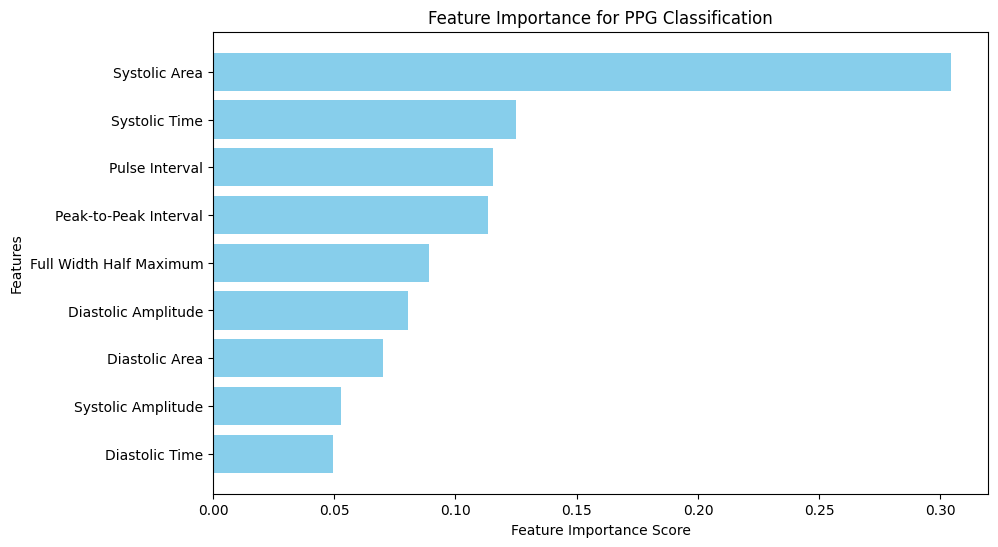

In [7]:
# Feature Importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance for PPG Classification")
plt.gca().invert_yaxis()
plt.show()

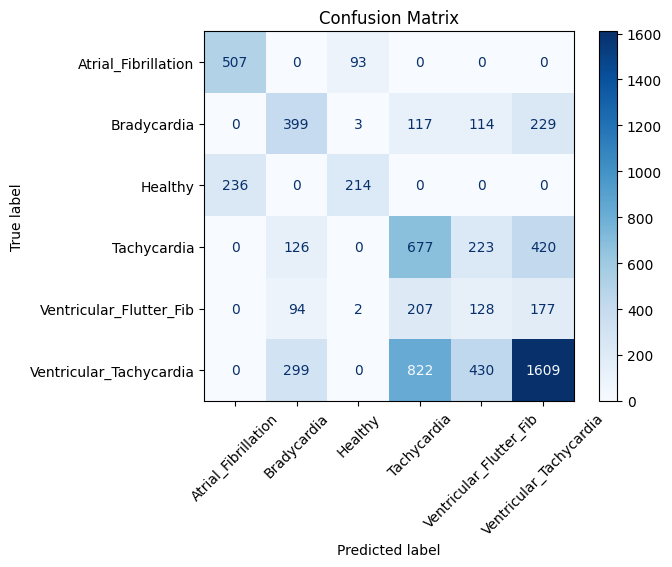

In [8]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)  # Adjust rotation as needed
plt.show()


In [11]:
import sys
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Convert labels to categorical (one-hot encoding)
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train_resampled))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

# Reshape input data for CNN (assuming X_train_resampled and X_test_scaled are numpy arrays)
X_train_cnn = np.expand_dims(X_train_resampled, axis=-1)
X_test_cnn = np.expand_dims(X_test_scaled, axis=-1)

# Define 1D CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(9, 1)),  # kernel_size=2
    BatchNormalization(),
    MaxPooling1D(pool_size=2),  
    
    Conv1D(filters=128, kernel_size=2, activation='relu'),  # kernel_size=2
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train_encoded.shape[1], activation='softmax')  
])


# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train_cnn, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test_cnn, y_test_encoded))

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test_cnn, y_test_encoded)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict & Decode Labels
y_pred = model.predict(X_test_cnn)
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_labels))


/Users/sarahalabdulrazzak/Desktop/Capstone/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.4791 - loss: 1.0897 - val_accuracy: 0.4374 - val_loss: 1.0951
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.5447 - loss: 0.9382 - val_accuracy: 0.4023 - val_loss: 1.2353
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.5530 - loss: 0.9260 - val_accuracy: 0.3931 - val_loss: 1.2369
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.5617 - loss: 0.9102 - val_accuracy: 0.3713 - val_loss: 1.3243
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - accuracy: 0.5623 - loss: 0.9021 - val_accuracy: 0.4608 - val_loss: 1.1634
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - accuracy: 0.5737 - loss: 0.8945 - val_accuracy: 0.3922 - val_loss: 1.2816
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - accuracy: 0.5758 - loss: 0.8887 - val_accuracy: 0.4092 - val_loss: 1.2617
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - accuracy: 0.5817 -

In [ ]:
import seaborn as sns

#  Convert one-hot encoded y_test back to labels
y_test_labels = np.argmax(y_test_encoded, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'sns' is not defined

<Figure size 800x600 with 0 Axes>